# Results Analysis #
--------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
import sys
import os
import warnings

warnings.filterwarnings('ignore')
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino'], 'size': 11})
CSV_PATH = "./data/P4_N4096000_STRONG_LOCAL/"

In [2]:
files = os.listdir(CSV_PATH)
forks = pd.concat([pd.read_csv(os.path.join(CSV_PATH, f)) for f in files if f.startswith("S0") and f.endswith(".csv")])
joins = pd.concat([pd.read_csv(os.path.join(CSV_PATH, f)) for f in files if f.startswith("S1") and f.endswith(".csv")])
forks = forks.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })
joins = joins.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })

display(forks.head(20))
display(joins.head(20))

,Time (ms),ID,Code,info1,info2
0,77.3672,0,CREATE,0.000000,0.000
0,77.4164,1,CREATE,0.000000,1.000
0,77.4516,2,CREATE,0.000000,2.000
0,77.4806,3,CREATE,0.000000,3.000
1,77.5937,0,SC_BGN,0.000000,NaN
2,77.5991,0,CHI_NO,3.000000,0.455
3,77.6063,0,SC_GLB,NaN,NaN
1,77.6792,3,RT_BGN,NaN,NaN
1,77.6799,1,RT_BGN,NaN,NaN
2,77.6862,3,RT_GLB,0.000000,NaN


,Time (ms),ID,Code,info1,info2
0,77.5074,0,CREATE,1.0,0.0
0,77.5317,1,CREATE,1.0,1.0
0,77.5619,2,CREATE,1.0,2.0
0,77.5890,3,CREATE,1.0,3.0
1,77.6920,3,SC_BGN,0.0,NaN
2,77.6960,3,SC_LOC,NaN,NaN
3,77.7224,3,SC_BGN,-1.0,NaN
4,77.7267,3,SC_LOC,NaN,NaN
5,77.7426,3,SC_BGN,-2.0,NaN
6,77.7459,3,SC_LOC,NaN,NaN


## Queue Dimensions ##

In [3]:
n_ws = len(forks.ID.unique())
loc_hs = np.zeros((n_ws, len(forks)))
glob_h = np.zeros(len(forks))

last_l = np.zeros(n_ws)
last_g = 0

for i, (t, wid, code, i1, i2) in enumerate(forks.itertuples(index=False, name=None)):
    if code == "SC_LOC":
        last_l[wid] += 1
    elif code == "RT_LOC":
        last_l[wid] -= 1
    elif code == "SC_GLB":
        last_g += 1
    elif code == "RT_GLB":
        last_g -= 1
    
    loc_hs[:, i] = last_l
    glob_h[i] = last_g

In [4]:
dfs = []

for i in range(n_ws):
    local = forks[['Time (ms)']].copy()
    local['Size'] = loc_hs[i, :]
    local['Queue'] = "$W_{}$".format(i)
    dfs.append(local)

glob = forks[['Time (ms)']].copy()
glob['Size'] = glob_h
glob['Queue'] = "Global"
dfs.append(glob)

queues = pd.concat(dfs).sort_values('Time (ms)')
queues[['Size', 'Queue']].groupby('Queue').describe()

Size                                             
          count      mean       std  min  25%  50%  75%  max
Queue                                                       
$W_0$   12300.0  3.791382  1.698770  0.0  3.0  4.0  5.0  9.0
$W_1$   12300.0  3.571707  1.755105  0.0  2.0  4.0  5.0  9.0
$W_2$   12300.0  3.792520  1.499234  0.0  3.0  4.0  5.0  8.0
$W_3$   12300.0  3.252927  1.531896  0.0  2.0  3.0  4.0  8.0
Global  12300.0  2.910732  1.642739  0.0  2.0  3.0  5.0  6.0

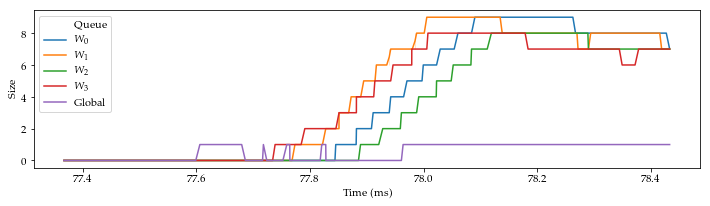

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(data=queues[:800], x='Time (ms)', y='Size', hue='Queue', hue_order=sorted(queues.Queue.unique()))
ax.legend()

plt.tight_layout()
plt.savefig("../report/figures/startup.pdf", format='pdf', bbox_inches='tight')
plt.show()

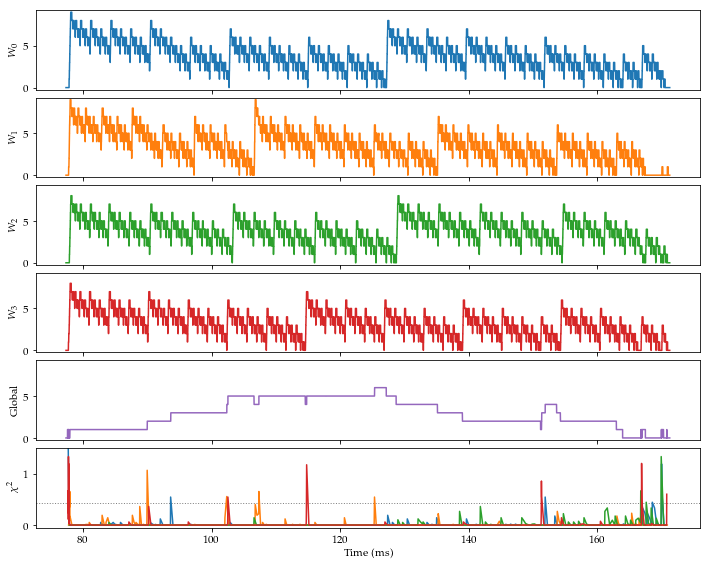

In [55]:
fig, axes = plt.subplots(n_ws + 2, 1, figsize=(10, 8), sharex=True)
max_size = queues['Size'].max()

for i, q in enumerate(sorted(queues.Queue.unique())):
    sns.lineplot(data=queues[queues.Queue == q], x='Time (ms)', y='Size', color='C{}'.format(i), ax=axes[i])
    axes[i].set_ylim((-0.25, max_size + 0.25))
    axes[i].set_ylabel(q)

chis = forks[forks.Code.apply(lambda c: c.startswith('CHI_'))].copy()
chis['info1'] = chis.apply(lambda r: 0. if r['Code'] == 'CHI_SK' else r['info1'], axis=1)

axes[n_ws+1].axhline(0.433, linestyle=':', linewidth=1., c='gray')

for i in range(n_ws):
    chis[chis.ID == i].plot(x='Time (ms)', y='info1', color='C{}'.format(i), ax=axes[n_ws+1])
    
axes[n_ws+1].set_ylabel(r'$\chi^2$')
axes[n_ws+1].get_legend().remove()
axes[n_ws+1].set_ylim((-0.05, 1.5))
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("../report/figures/queues.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Waiting Time ##

In [7]:
n_ws = len(forks.ID.unique())
rt_wait = np.zeros((n_ws, len(forks)), dtype=bool)
sc_wait = np.zeros((n_ws, len(forks)), dtype=bool)

last_rt = np.zeros(n_ws, dtype=bool)
last_sc = np.zeros(n_ws, dtype=bool)

for i, (t, wid, code, i1, i2) in reversed(list(enumerate(forks.itertuples(index=False, name=None)))):
    if code == "SC_GLB":
        last_sc[wid] = True
    elif code == "RT_GLB":
        last_rt[wid] = True
    elif code == "SC_BGN":
        last_sc[wid] = False
    elif code == "RT_BGN":
        last_rt[wid] = False
    
    rt_wait[:, i] = last_rt
    sc_wait[:, i] = last_sc
    
rt_wait = np.logical_or(rt_wait, np.roll(rt_wait, 1, axis=1))
sc_wait = np.logical_or(sc_wait, np.roll(sc_wait, 1, axis=1))

In [8]:
dfs = []

for i in range(n_ws):
    rt = forks[['Time (ms)']].copy()
    rt['Idle'] = rt_wait[i, :]
    rt['Type'] = 'Retrieve'
    rt['Worker'] = i
    dfs.append(rt)
    
    sc = forks[['Time (ms)']].copy()
    sc['Idle'] = sc_wait[i, :]
    sc['Type'] = 'Schedule'
    sc['Worker'] = i
    dfs.append(sc)

wait = pd.concat(dfs).sort_values('Time (ms)')
wait.head()

,Time (ms),Idle,Type,Worker
0,77.3672,False,Retrieve,0
0,77.3672,False,Retrieve,2
0,77.3672,False,Retrieve,3
0,77.3672,False,Schedule,1
0,77.3672,False,Retrieve,1


In [9]:
wait_plot = wait.copy()

wait_plot.loc[:, 'Idle'] = wait.apply(lambda r: r['Worker'] if r['Idle'] else np.nan, axis=1)
wait_plot = wait_plot.dropna()

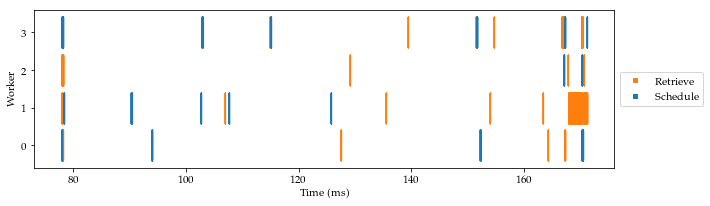

In [10]:
fig, ax = plt.subplots(figsize=(10, 3))
legend_elements = []

for t in sorted(wait_plot.Type.unique()):
    c = 'C0' if t == "Schedule" else 'C1'
    legend_elements.append(Line2D([0], [0], color='w', marker='s', markerfacecolor=c, label=t))
    
    for wid in sorted(wait_plot.Worker.unique()):
        ax.scatter(x=wait_plot[wait_plot.Type == t]['Time (ms)'], 
                   y=wait_plot[wait_plot.Type == t]['Idle'], 
                   marker='$|$', 
                   linewidth=0, 
                   s=1000,
                   color=c)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Worker")
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("../report/figures/idletime.pdf", format='pdf', bbox_inches='tight')
plt.show()